<a href="https://colab.research.google.com/github/sandje00/nn-image-classification/blob/master/img_class_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image classification - CNN


Multiclass image scene classification using convolutional neural network

**Dataset**: [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification)




## Imports

In [0]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [0]:
drive.mount('/content/drive')

In [0]:
!unzip -q '/content/drive/My Drive/intel-image-classification.zip'

In [0]:
class_names = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Preparing the data

Function `load_image_data()` receives path and traverses the dir tree using `os.scandir()`. Each image is resized to 150 x 150 and assigned a label, which is subdirectory name. Array elements of images and labels are bound with `zip()` and then randomly shuffled.

In [0]:
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'

In [0]:
def load_image_data(path):
    Images = []
    Labels = []
    label = 0

    for entry in os.scandir(path):
        if entry.is_dir():
            if entry.name == 'buildings':
                label = 0
            elif entry.name == 'forest':
                label = 1
            elif entry.name == 'glacier':
                label = 2
            elif entry.name == 'mountain':
                label = 3
            elif entry.name == 'sea':
                label = 4
            elif entry.name == 'street':
                label = 5

        for img_entry in os.scandir(path + r'/' + entry.name):
            image = cv2.imread(path + r'/' + entry.name + r'/' + img_entry.name)
            image = cv2.resize(image, (150,150))

            Images.append(image)
            Labels.append(label)
    
    zipped = list(zip(Images, Labels))
    random.shuffle(zipped)
    Images, Labels = zip(*zipped)
        
    return Images, Labels

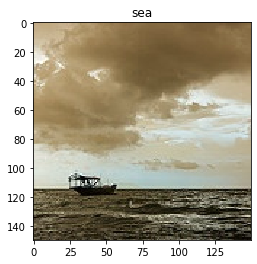

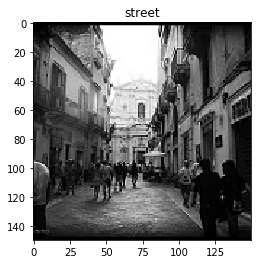

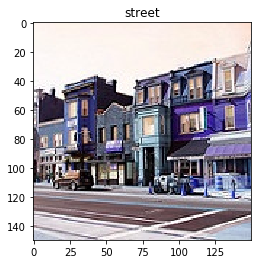

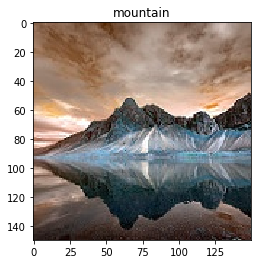

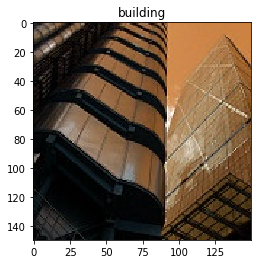

In [0]:
train_images, train_labels = load_image_data(train_path)
test_images, test_labels = load_image_data(test_path)

for i in range(5):
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.title("{}".format(class_names[train_labels[i]]))
    plt.show()

Train/test images/labels are converted into numpy array and divided by 255.0. Each pixel is represented by three values between 0 and 255, which determines the intensity of red, green and blue respectively. By division with 255.0 dataset is "shrunk", i. e. scaled because of easier computation.

In [0]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [0]:
train_images = train_images/255.0
test_images = test_images/255.0

## CNN Model

This model consists of two parts: stack of convolutional and pooling layers and stack of fully connected layers.

![](https://miro.medium.com/max/772/1*kkyW7BR5FZJq4_oBTx3OPQ.png)

**Convolutional layers** - performing convolution, i. e. computing element-wise multiplication of image pixel values with values of filters a. k. a. *kernels*. With filters network identifies certain features on the image. Activation function is *Rectified linear unit*.

**Pooling layers** - down sampling the input of convolutional layer, i. e. creating the representation of convolutional layer output of lower resolution, but it still contains relevant information.

**Fully connected layers** - multilayer perceptron architecture that performs classification based on the output of convolutional and pooling layers.

### Overfitting minimization

**Batch normalization** - allowing a layer to learn more independently of other layers (used after each convolutional layer).

**Dropout** - randomly selects nodes to be dropped out with given probability (at the input of MLP stacl probability of 0.2, and probability of 0.5 before the output layer)

In [0]:
cnn = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)), #convolutional layers
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(96, kernel_size = (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(96, kernel_size = (5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(), #mlp
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation = 'softmax')
])

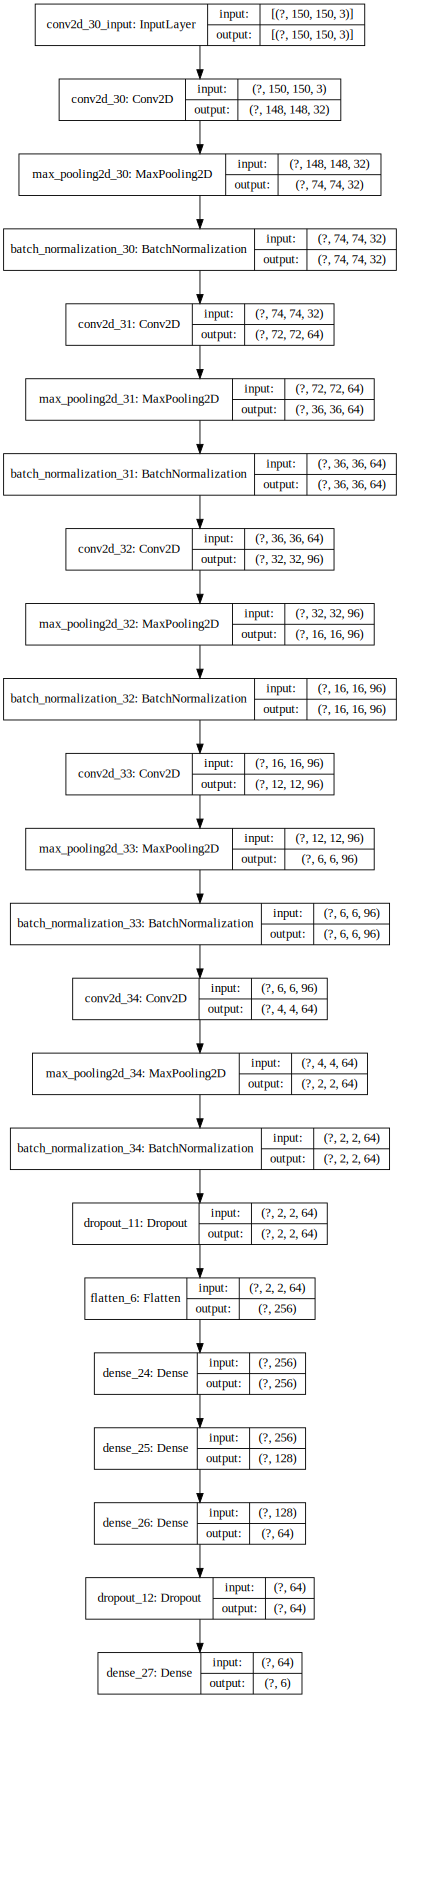

In [0]:
SVG(model_to_dot(
    cnn, show_shapes=True, show_layer_names=True, rankdir='TB',
    expand_nested=False, dpi=65, subgraph=False
).create(prog='dot', format='svg'))

In [0]:
adam = keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
cnn.compile(optimizer = adam, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [0]:
History = cnn.fit(train_images, train_labels, epochs = 20)

Train on 14034 samples
Epoch 1/20
14034/14034 [==============================] - 12s 878us/sample - loss: 1.2335 - acc: 0.5244
Epoch 2/20
14034/14034 [==============================] - 12s 860us/sample - loss: 0.8401 - acc: 0.7000
Epoch 3/20
14034/14034 [==============================] - 12s 870us/sample - loss: 0.7217 - acc: 0.7465
Epoch 4/20
14034/14034 [==============================] - 12s 861us/sample - loss: 0.6406 - acc: 0.7781
Epoch 5/20
14034/14034 [==============================] - 12s 868us/sample - loss: 0.5748 - acc: 0.8043
Epoch 6/20
14034/14034 [==============================] - 12s 857us/sample - loss: 0.5288 - acc: 0.8205
Epoch 7/20
14034/14034 [==============================] - 12s 862us/sample - loss: 0.4758 - acc: 0.8409
Epoch 8/20
14034/14034 [==============================] - 12s 854us/sample - loss: 0.4384 - acc: 0.8513
Epoch 9/20
14034/14034 [==============================] - 12s 852us/sample - loss: 0.3998 - acc: 0.8640
Epoch 10/20
14034/14034 [================

In [0]:
test_loss, test_accuracy = cnn.evaluate(test_images, test_labels)

print("Test accuracy: {}".format(test_accuracy))

3000/3000 [==============================] - 2s 567us/sample - loss: 0.6453 - acc: 0.8340
Test accuracy: 0.8339999914169312


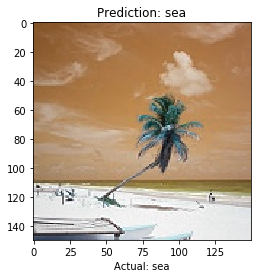

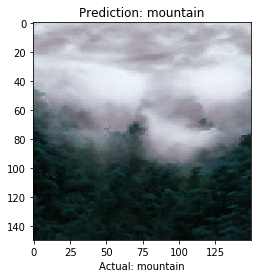

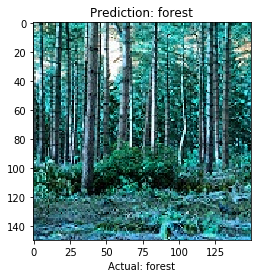

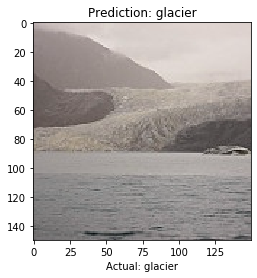

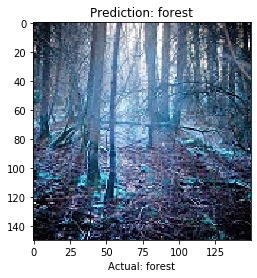

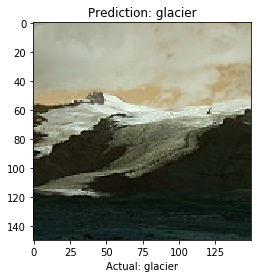

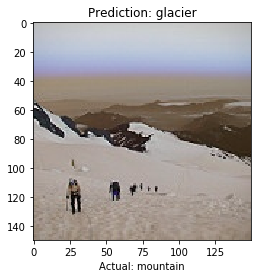

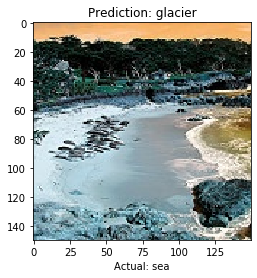

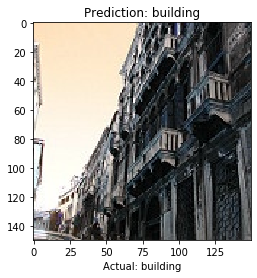

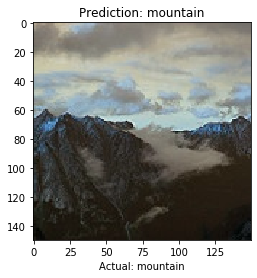

In [0]:
prediction = cnn.predict(test_images)

for i in range(10):
    plt.grid(False)
    plt.imshow(test_images[i])
    plt.xlabel("Actual: {}".format(class_names[test_labels[i]]))
    plt.title("Prediction: {}".format(class_names[np.argmax(prediction[i])]))
    plt.show()